In [21]:
import import_ipynb
from planta import *
from requisitos import *

# autoreload sets up auto reloading of modified .py modules
import autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 


0.009491 z^2 + 0.02608 z + 0.00422
----------------------------------
z^3 - 1.987 z^2 + 1.223 z - 0.1957

dt = 0.0021929824561403508

zeros: [-2.57559482 -0.17263649]
polos: [0.87024457+0.18969783j 0.87024457-0.18969783j 0.2466522 +0.j        ]


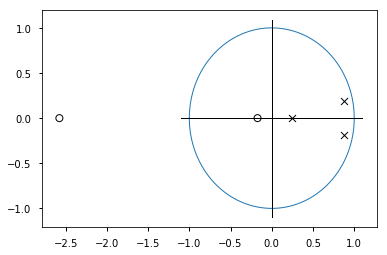

In [22]:
zplane(G_z)
print(G_z)
print(f'zeros: {zero(G_z)}')
print(f'polos: {pole(G_z)}')


  1
-----
z - 1

dt = 0.0021929824561403508



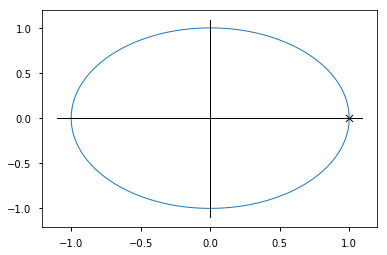

In [23]:
integrador = tf([0, 1], [1, -1], Ts)
print(integrador)
zplane(integrador)

4 states have been removed from the model

       0.009491
----------------------
z^2 - 1.247 z + 0.2467

dt = 0.0021929824561403508



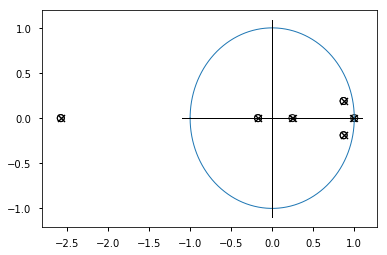

In [24]:
z = zero(G_z)
p = pole(G_z)
# cancelamento = tf(np.poly([*pole(G_z)]), np.poly([*zero(G_z)]), Ts)
# cancelamento = tf(np.poly(pole(G_z)[0:2]), 1, Ts)
cancelamento = tf(np.poly(pole(G_z)[0:2]), np.poly(zero(G_z)[0:]), Ts)
# cancelamento = 1
Gg_z = G_z * cancelamento * integrador
zplane(Gg_z/(1+Gg_z))
Gg_z = minreal(Gg_z)
print(Gg_z)

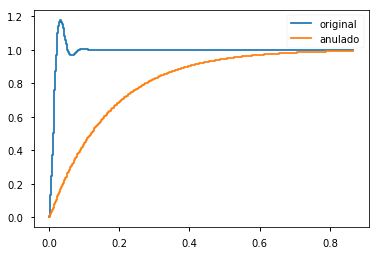

In [25]:
final_time = 35 * Req['SettlingTime']
T = np.arange(final_time / Ts) * Ts
yout, T = step(G_z, T)
plt.step(T, yout)
yout, T = step(Gg_z/(1+Gg_z), T)
plt.step(T, yout)
plt.legend(['original', 'anulado'])

Identificamos os seus polos e zeros:

In [26]:
poles = pole(G_z)
zeros = zero(G_z)

print(f'polos: {poles}')
print(f'zeros: {zeros}')

polos: [0.87024457+0.18969783j 0.87024457-0.18969783j 0.2466522 +0.j        ]
zeros: [-2.57559482 -0.17263649]


Considerando a planta do controlador como:

$$ 
    G_D(z) = K\,
    \frac{(z+\alpha)(z+\alpha^*)}{(z-1)(z+\beta)} $$

In [27]:
# alpha para cancelar o polo complexo do controlador
alpha = pole(G_z)[0]
print(f'a = {alpha}')

a = (0.8702445709865086+0.1896978275264907j)


Para que $P_1$ seja o lugar das raízes, a soma dos ângulos de polos e zeros em relação à $P_1$ deve ser igual a $\pm$ 180°:

Ângulo dos polos: -1.5836906673074824 rad, -90.73879129097573°
Ângulo dos zeros: -1.3348107390405477 rad, -76.47902179576168°
Somatório dos ângulos: 0.24887992826693472 rad, 14.259769495214037°
Ângulo que o polo do controlador deve fornecer: 1.3219163985279618 rad, 75.74023050478597°
b = -0.30754359929336683


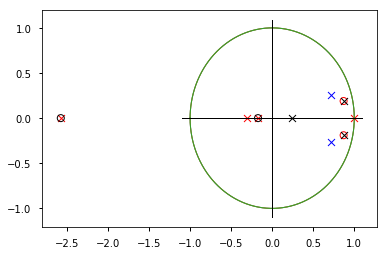

In [28]:
def wrap(angle):
    return np.arctan(np.tan(angle))

angle_zeros = np.sum(wrap(np.angle(p1 -zero(G_z * cancelamento * integrador))))
angle_poles = np.sum(wrap(np.angle(p1 -pole(G_z * cancelamento * integrador))))
angle_sum = angle_zeros - angle_poles
alpha_angle = np.angle(alpha -alpha.conjugate())
angle_beta = wrap(-np.pi - angle_sum -alpha_angle)

print(f'Ângulo dos polos: {angle_poles} rad, {np.rad2deg(angle_poles)}°')
print(f'Ângulo dos zeros: {angle_zeros} rad, {np.rad2deg(angle_zeros)}°')
print(f'Somatório dos ângulos: {angle_sum} rad, {np.rad2deg(angle_sum)}°')
print(f'Ângulo que o polo do controlador deve fornecer: {angle_beta} rad, {np.rad2deg(angle_beta)}°')

# Considerando dois triângulos retângulos podemos:
beta = ( p1.real +np.tan(angle_beta) * (-(p1).imag) )
print(f'b = {beta}')

Gd_z_over_k = tf(1, np.poly([beta]), Ts) * cancelamento * integrador

# print(f'Gd(z)/k = {Gd_z_over_k}')
zplane(Gd_z_over_k, color='red')
zplane(G_z)
zplane(polo_dominante_desejado, color='blue')

O ganho $K$ pode ser determinado pela condição de módulo:

$$ |G_D(z) * G(z)|_{z = z1} = 1 $$

4 states have been removed from the model
k = (23.151083185149194-1.8424439564037747e-13j)
k = 19.678420707376816


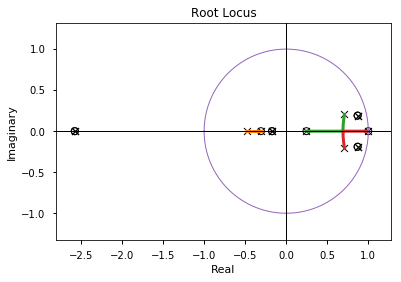

In [90]:
FTMA_over_k = minreal(Gd_z_over_k * G_z)
# print(f'FTMA(z)/k = {FTMA_over_k}')
# print(f'P1 = {p1}')

k = -np.polyval(FTMA_over_k.den[0][0], p1) / np.polyval(FTMA_over_k.num[0][0], p1)
if np.abs(k.imag) > 1e-10:
    print('Não há valor de k que garanta que P1 seja o lugar das raízes.')
print(f'k = {k}')
# k = np.abs(k.real)
k = np.abs(k)
print('Usando 80% do k encontrado parece nos dar uma performance mais segura em relação às variações da placa')
k = 0.85 * k
print(f'k = {k}')

Gd_z = k * Gd_z_over_k
# print(f'Gd(z) = {Gd_z}')
FTMA = Gd_z * G_z
# print(f'FTMA(z) = {FTMA}')

FTMF = (FTMA / (1 + FTMA))
# print(f'FTMF(z) = {FTMF}')

yout, _ = rlocus(FTMA_over_k, np.linspace(0, k, 1000))
zplane(FTMF)

11 states have been removed from the model
FTMF(z) = 
               0.1868
------------------------------------
z^3 - 0.9391 z^2 - 0.1367 z + 0.2626

dt = 0.0021929824561403508



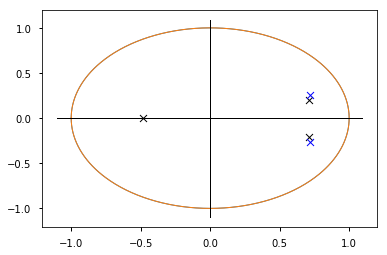

In [91]:
FTMF = minreal(FTMF)
print(f'FTMF(z) = {FTMF}')

zplane(FTMF)
zplane(polo_dominante_desejado, color='blue')

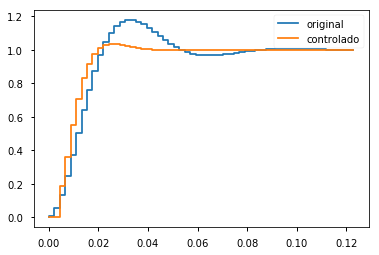

In [92]:
final_time = 5 * Req['SettlingTime']
T = np.arange(final_time / Ts) * Ts
yout, T = step(G_z, T)
plt.step(T, yout)
yout, T = step(FTMF, T)
plt.step(T, yout)
plt.legend(['original', 'controlado'])

In [93]:
print('\n-> Sem controlador:')
print(json.dumps(S, indent=4))
print('\n-> Com controlador:')
FTMF_info = stepinfo(FTMF, SettlingTimeThreshold=SettlingTimeThreshold)
print(json.dumps(FTMF_info, indent=4))
print('\n-> Requisitos:')
print(json.dumps(Req, indent=4))


-> Sem controlador:
{
    "RiseTime": 0.014733110889278787,
    "SettlingTime": 0.04955682753666501,
    "SettlingMin": 0.9474371557000978,
    "SettlingMax": 1.1805086179959798,
    "Overshoot": 18.178443153933472,
    "Undershoot": 0.0,
    "Peak": 1.1805086179959798,
    "PeakTime": 0.03348434293017906,
    "SteadyStateValue": 0.9989204346331648
}

-> Com controlador:
{
    "RiseTime": 0.010964912280701754,
    "SettlingTime": 0.019736842105263157,
    "SettlingMin": 0.9178875841812607,
    "SettlingMax": 1.0352199310196042,
    "Overshoot": 3.5219931020585484,
    "Undershoot": 0.0,
    "Peak": 1.0352199310196042,
    "PeakTime": 0.02631578947368421,
    "SteadyStateValue": 0.9999999999990521
}

-> Requisitos:
{
    "SettlingTime": 0.024778413768332504,
    "Overshoot": 9.089221576966736
}
